# Inferring Measurement Error of ∆F From Wild-Type Measurements

© 2018 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [148]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import mut.viz
import mut.thermo
import mut.stats
import mut.bayes
import matplotlib.pyplot as plt
import tqdm 
import seaborn as sns
mut.viz.plotting_style()
colors = mut.viz.color_selector('mut')
pboc = mut.viz.color_selector('pboc')
constants = mut.thermo.load_constants()

In [149]:
# Load the induction paper data
data = pd.read_csv('../../data/csv/RazoMejia2018_data.csv')
data['repressors'] *= 2
data.rename(columns={'fold_change_A':'fold_change',
                    'IPTG_uM':'IPTGuM'}, inplace=True)
data = data[data['repressors'] > 0].copy()

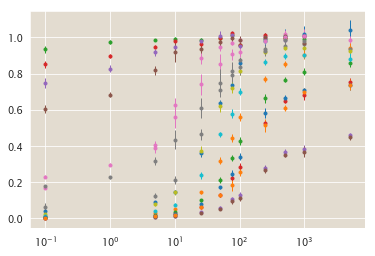

In [151]:
# repressor_colors = 
for g, d in data.groupby(['operator', 'repressors']):
    _d = d.groupby(['IPTGuM']).agg(('mean', 'sem')).reset_index()
    plt.errorbar(_d['IPTGuM'], _d['fold_change']['mean'], _d['fold_change']['sem'],
                 lw=1, capsize=0, linestyle='none',fmt='.')
plt.xscale('log')


In [152]:
# Compute the reference bohr for each measurement. 
ref_bohr = -mut.thermo.SimpleRepression(R=data['repressors'], ep_r=data['binding_energy'],
                                      ka=constants['Ka'], ki=constants['Ki'], 
                                      ep_ai=constants['ep_AI'], effector_conc=data['IPTGuM']).bohr_parameter()
data['ref_bohr'] = ref_bohr

In [168]:
# Load the stan model. 
model = mut.bayes.StanModel('../stan/empirical_F.stan', force_compile=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_00a2fc2ceeec92ecc0afdd124744a0f0 NOW.


Precompiled model not found. Compiling model...


/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmp2rzolszv/stanfit4anon_model_00a2fc2ceeec92ecc0afdd124744a0f0_8452674058691583154.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


finished!


In [170]:
# Loop through each unique repressor, operator, and IPTG and calculate the ∆F. 
dbohr_stats = []
for g, d in tqdm.tqdm(data.groupby(['repressors', 'operator', 'IPTGuM'])):
    data_dict = {'N':len(d), 'ref_bohr':d['ref_bohr'].values[0],
                'foldchange':d['fold_change']}
    fit, samples = model.sample(data_dict, iter=5000)
    
    # Compute the stats. 
    stats = mut.stats.compute_statistics(samples, varnames=['delta_bohr'], 
                                        logprob_name='lp__')
    _corrstats = mut.stats.compute_statistics(samples, varnames=['delta_bohr_corr'],
                                             logprob_name='lp__')
    stats['repressors'] = g[0]
    stats['operator'] = g[1]
    stats['IPTGuM'] = g[2]
    stats['mean_corr'] = _corrstats['mean']
    stats['median_corr'] = _corrstats['median']
    stats['min_corr'] = _corrstats['hpd_min']
    stats['max_corr'] = _corrstats['hpd_max']
    
    dbohr_stats.append(stats)
dbohr = pd.concat(dbohr_stats)





  0%|          | 0/216 [00:00<?, ?it/s]WARNING:pystan:n_eff / iter for parameter delta_bohr_corr is nan!




  0%|          | 1/216 [00:00<02:06,  1.70it/s]



  1%|          | 2/216 [00:01<02:02,  1.75it/s]



  1%|▏         | 3/216 [00:01<02:00,  1.77it/s]WARNING:pystan:n_eff / iter for parameter delta_bohr_corr is nan!




  2%|▏         | 4/216 [00:02<01:59,  1.78it/s]



  2%|▏         | 5/216 [00:02<01:56,  1.81it/s]



  3%|▎         | 6/216 [00:03<01:55,  1.82it/s]



  3%|▎         | 7/216 [00:03<01:53,  1.83it/s]



  4%|▎         | 8/216 [00:04<01:46,  1.96it/s]



  4%|▍         | 9/216 [00:05<02:40,  1.29it/s]WARNING:pystan:1 of 10000 iterations ended with a divergence (0.01%).




  5%|▍         | 10/216 [00:06<02:25,  1.41it/s]



  5%|▌         | 11/216 [00:06<02:14,  1.52it/s]



  6%|▌         | 12/216 [00:07<02:06,  1.61it/s]



  6%|▌         | 13/216 [00:07<02:01,  1.67it/s]



  6%|▋         | 14/216 [00:08<01:57,  1.73it/s]



  7%|▋         | 15/216 [00:08<0

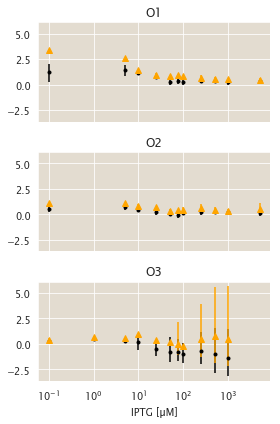

In [176]:
fig, ax = plt.subplots(3, 1, figsize=(4, 6), sharex=True, sharey=True)
axes = {'O1':ax[0], 'O2':ax[1], 'O3':ax[2]}
for g, d in dbohr.groupby(['operator', 'repressors']):
    _ax = axes[g[0]]
    if g[1] == 1220:
        d = d.sort_values('IPTGuM')
        _ax.plot(d['IPTGuM'], d['median'], '.', color='k')
        _ax.plot(d['IPTGuM'], d['median_corr'], '^', color='orange')
    
        _ax.vlines(d['IPTGuM'], d['hpd_min'], d['hpd_max'], color='k')
        _ax.vlines(d['IPTGuM'], d['min_corr'], d['max_corr'], color='orange')

   
titles = ['O1', 'O2', 'O3']
for i, a in enumerate(ax):
    a.set_xscale('log')
    a.set_title(titles[i])
ax[-1].set_xlabel('IPTG [µM]')

plt.tight_layout()

In [ ]:
plt.plot(samples['fc_mu'], samples['fc_sigma'], ',')
plt.xlim([0, 1])


In [ ]:
plt.plot(samples['empirical_bohr'], np.log((1/samples['fc_sigma']) - 1), '.')

In [ ]:
dbohr